In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-28_13-47_20180601_20191231_base_fixed.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

GC       0.25
ES       0.25
NQ       0.25
YM       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    22802.60
GC     6466.64
NQ    34341.80
YM    31639.80
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

95250.84000000001

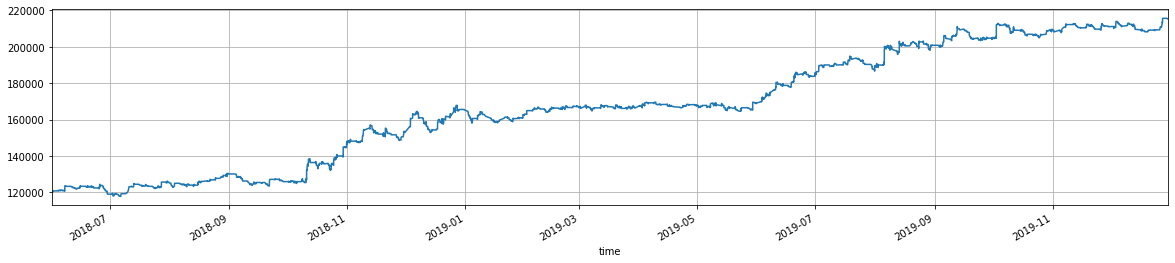

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     344
 GC    1208
 NQ    1892
 YM     612
 Name: action, dtype: int64, 4056)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.834951
 GC    2.932039
 NQ    4.592233
 YM    1.485437
 Name: action, dtype: float64, 9.844660194174757)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     722.40
GC    2923.36
NQ    3973.20
YM    1285.20
Name: commission, dtype: float64

In [15]:
df.commission.sum()

8904.160000000002

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.36,10.71,485.25,-259.23,1.87,8.78,604.0
NQ,0.41,36.30,456.51,-252.08,1.81,38.44,946.0
YM,0.41,103.40,808.50,-377.00,2.14,109.05,306.0
ES,0.45,132.57,984.76,-558.15,1.76,136.16,172.0
total,0.40,46.97,569.08,-296.70,1.92,49.61,2028.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.051469,0.190874,0.394498,0.629104
GC,-0.051469,1.000000,0.055598,0.084735,0.423360
NQ,0.190874,0.055598,1.000000,0.278309,0.654127
YM,0.394498,0.084735,0.278309,1.000000,0.721374
total,0.629104,0.423360,0.654127,0.721374,1.000000


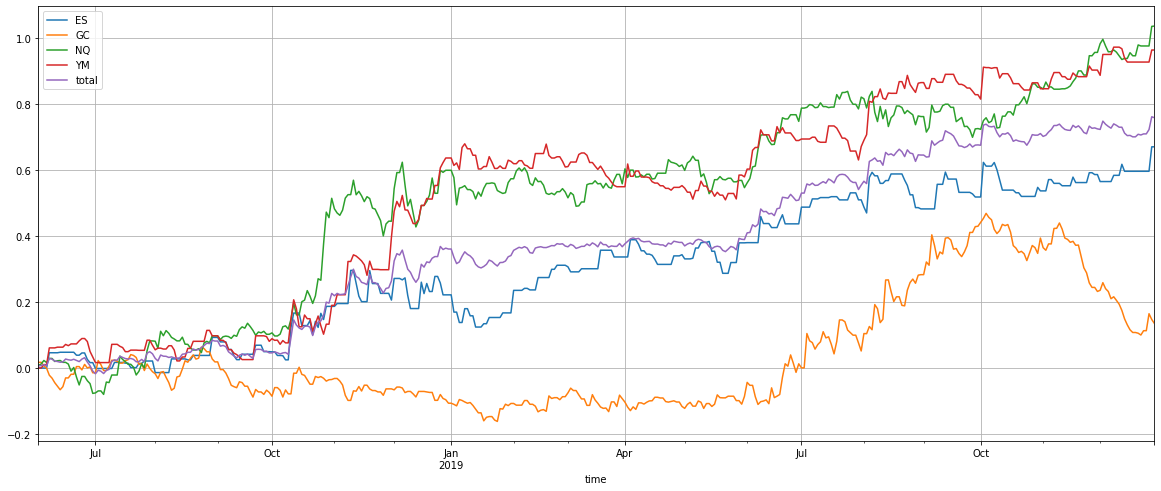

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

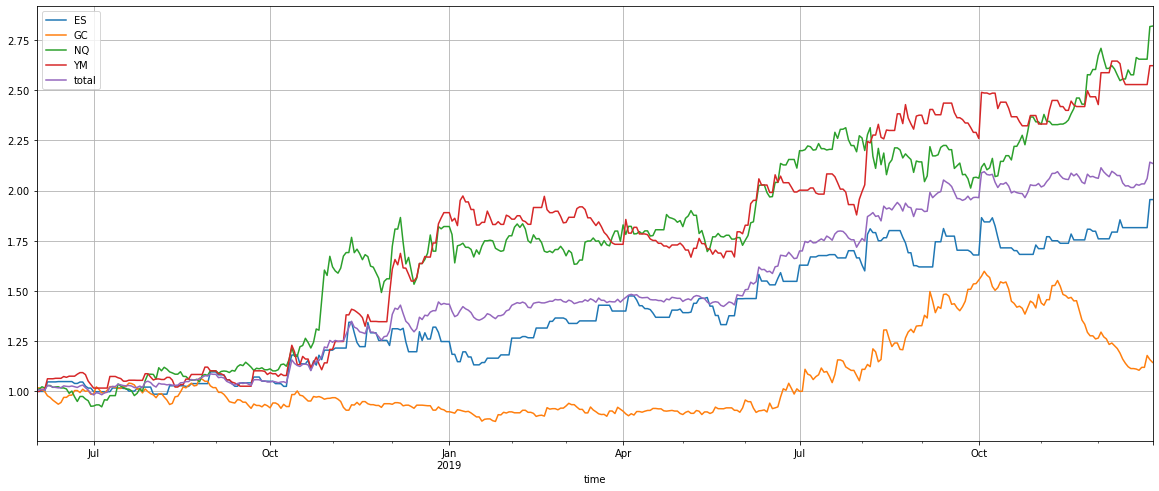

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.506822,0.086009,0.884725,0.802998,0.590349
Cumulative returns,0.954867,0.144419,1.818439,1.621393,1.135130
Annual volatility,0.335850,0.318268,0.365047,0.336674,0.207440
Sharpe ratio,1.384269,0.414255,1.918032,1.916048,2.340447
Calmar ratio,3.212571,0.278918,4.968685,5.140254,6.355380
Stability,0.941261,0.417134,0.893287,0.897439,0.960826
Max drawdown,-0.157762,-0.308367,-0.178060,-0.156218,-0.092890
Omega ratio,1.464539,1.082385,1.447039,1.554798,1.576797
Sortino ratio,2.840509,0.765836,3.332226,4.205861,4.969045
Skew,2.171188,1.882121,0.781140,1.954259,1.692350


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.65,-1.43,-7.40,3.37,-0.92
2018-07-31,0.49,0.32,17.25,3.65,5.38
2018-08-31,7.41,3.02,1.57,2.90,3.94
2018-09-30,-4.22,-8.83,0.45,-1.65,-3.53
2018-10-31,14.71,3.99,51.00,11.52,19.76
2018-11-30,1.92,-2.79,-6.70,22.96,3.86
2018-12-31,1.60,-4.25,16.67,27.11,10.15
2019-01-31,-5.32,-0.08,-2.53,-1.01,-1.96
2019-02-28,15.53,2.07,-3.95,-1.70,2.92


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        95.0
GC        14.0
NQ       182.0
YM       162.0
total    114.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-08-05 21:22:30,ES,BUY,2843.00,3408.30
2019-10-02 21:00:00,ES,BUY,2893.75,3320.80
2019-07-03 00:21:30,GC,SELL,1433.40,3245.16
2019-08-05 21:19:00,YM,BUY,25615.00,3190.80
2018-11-08 20:40:00,YM,SELL,26092.00,3180.80
...,...,...,...,...
2018-12-18 21:49:00,ES,BUY,2559.75,-1204.20
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.20
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.022011,0.035793,0.106360,0.069444
2019-10-02,0.110693,0.012183,0.026633,0.101693,0.062801
2018-12-03,0.067777,-0.002989,0.103553,0.081860,0.062550
2018-10-11,0.044580,0.064688,0.050440,0.061913,0.055405
2018-10-10,0.103193,0.000000,0.030073,0.073053,0.051580
...,...,...,...,...,...
2018-11-21,-0.038473,-0.004828,-0.028447,-0.024640,-0.024097
2019-01-02,-0.050973,-0.003495,-0.021780,-0.022307,-0.024639
2018-10-22,-0.041530,0.000000,-0.021920,-0.037113,-0.025141
